# Introduction: Bayesian Linear Regression Project

In this notebook, we will implement a complete machine learning project, focusing on Bayesian Inference methods, in particular, Bayesian Linear Regression. We will go through the entire machine learning process, cleaning the data, exploring it to find trends, establishing a baseline model, evaluating several machine learning approaches for comparisons, implementing Bayesian Linear Regression, interpreting the results, and presenting the results. Let's get started!

## Dataset

We are using data on student grades collected from a Portuguese secondary (high) school. This data is from the [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/student+performance#), a great collection of datasets for model testing. The data includes academic and personal characteristics of the students as well as final grades. The objective is to predict the final grade from the student information which makes this a __supervised, regression task__. We have a set of training data with known labels, and we want the model to learn a mapping from the features (explanatory variables) to the target (the label) in this case the final grade. It is a regression task because the final grade is a continuous value.

# Exploratory Data Analysis

In [118]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)

 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

from IPython.core.pylabtools import figsize

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

In [119]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy

In [120]:
# PyMC3 for Bayesian Inference
import pymc3 as pm

## Read in Data and Examine

In [121]:
# Read in class scores
df = pd.read_csv('df_dr.csv')
print(list(df.columns))
target_col = 'human_ratingmean'
# other_targets= ['index', 'M', 'A', 'human_bin', 'expert_bin',
#        'consensus', 'pm', 'pa', 'category', 'interval', 'interval_10',
#        'interval_20', 'regr_labels_20', 'regr_labels','1v1', 'phase', 'human_rating', 'idx', 'pass']

other_targets=['human_rating.count', 'human_rating.sem', 'expert_rating.first', 
               'expert_rating.last', 'expert_rating.mean', 'human_rating', 
               'expert_rating', 'start', 'end', 'spread', 'interval_3', 
               'interval_5', 'interval_10', 'TSNE_1','TSNE_2','expert_rating.cat', 'expert_consensus']

df = df.drop(other_targets, axis=1)

print(list(df.columns))

df.columns = [col.replace('.', '') for col in df.columns]

df.columns = [col.replace('/', '') for col in df.columns]


df = df.sort_values(['filename'], ascending=True)
df.head()

['filename', 'type', 'class', 'human_rating.mean', 'human_rating.count', 'human_rating.sem', 'expert_rating.first', 'expert_rating.last', 'expert_rating.mean', 'human_rating', 'expert_rating', 'start', 'end', 'spread', 'interval_3', 'interval_5', 'interval_10', 'PCA_1', 'TSNE_1', 'PCA_2', 'TSNE_2', 'PCA_3', 'PCA_4', 'PCA_5', 'expert_rating.cat', 'expert_consensus']
['filename', 'type', 'class', 'human_rating.mean', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']


,filename,type,class,human_ratingmean,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,1,0.818667,1.853032,0.398556,0.144556,-0.026213,0.010690
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,1,0.812000,1.853032,0.398556,0.144556,-0.026213,0.010690
2,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,2,0.802500,1.880028,0.429649,0.050169,-0.006649,0.040476
3,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,3,0.804000,1.860662,0.444598,0.112088,-0.070397,-0.016060
4,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,2,0.766667,1.880028,0.429649,0.050169,-0.006649,0.040476


In [122]:
df.columns

best_cols = ['bt_0.1_ce',
 'bt_0.05_ce','cbsg_0.2_cp', 'knn_4.0_cp','as_0.1_cp',
 'del_na_cp',
 'knn_8.0_ce',
 'knn_4.0_ce',
 'cbsg_0.2_ce',
 'knn_6.0_ce',
 'cbsg_0.5_ce',
 'cbsg_0.1_ce',
 'knn_2.0_ce',
 'knn_1.0_cp',
 'cbsg_2.0_ce',
 'bt_0.5_ce',
 'bt_0.02_ltcc',
 'bt_0.5_ltcc',
 'bt_0.05_ltcc']

best_cols = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']

### Describe for Numerical Columns

In [123]:
df.describe()

,class,human_ratingmean,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
count,892.000000,892.000000,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02,8.920000e+02
mean,2.356502,0.501076,3.186290e-17,-1.354173e-16,1.354173e-16,5.177722e-17,-1.632974e-16
std,1.063966,0.237277,1.570828e+00,5.875374e-01,3.860088e-01,3.351726e-01,2.722803e-01
min,1.000000,0.040714,-3.517839e+00,-1.813430e+00,-1.339949e+00,-1.814897e+00,-1.237638e+00
25%,1.000000,0.320790,-1.385848e+00,-3.261102e-01,-2.278438e-01,-1.790623e-01,-1.515243e-01
50%,2.000000,0.492566,4.665374e-01,2.995686e-02,3.940816e-02,-4.790811e-03,1.455567e-02
75%,3.000000,0.736742,1.374074e+00,3.929988e-01,2.370701e-01,1.895201e-01,1.545291e-01
max,4.000000,0.960909,2.109217e+00,1.595274e+00,1.036787e+00,1.279472e+00,7.622721e-01


### Value Counts for Categorical Columns

In [124]:
# Print the value counts for categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        print('\nColumn Name:', col,)
        print(df[col].value_counts())


Column Name: filename
interleaved_100_200_15d_25_cramped_rotated_PCA        8
interleaved_100_200_10d_25_cramped_rotated_PCA        8
interleaved_100_200_4d_0_notcramped_notrotated_PCA    8
tse300_PCA                                            8
grid6_4d_GlimmerMDS                                   8
                                                     ..
n100-d5-c3-spr0.1-out0_GlimmerMDS                     6
n100-d10-c3-spr0.1-out0_PCA                           6
ms_interleaved_60_120_3d_0_centeredClusters_tSNE      6
n500-d5-c3-spr0.1-out0_PCA                            6
boston_tSNE                                           6
Name: filename, Length: 123, dtype: int64

Column Name: type
semantic    446
abstract    446
Name: type, dtype: int64


### Distribution of Grades

#### Grade Distribution by Different Categorical Variables

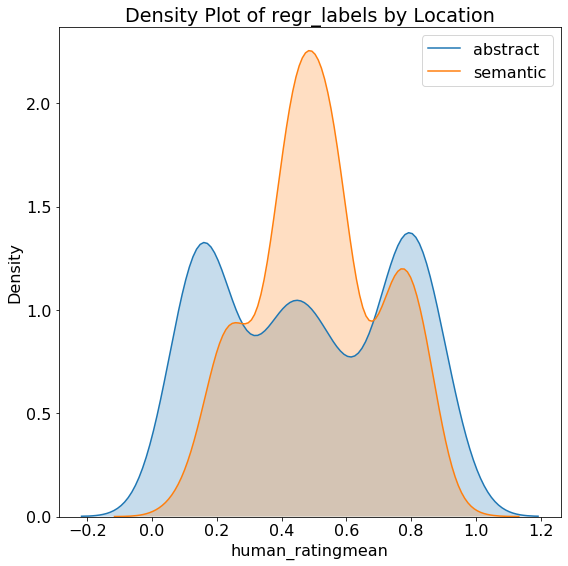

In [125]:
# Grade distribution by address
sns.kdeplot(df.loc[df['type'] == 'abstract', target_col], label = 'abstract', shade = True)
sns.kdeplot(df.loc[df['type'] == 'semantic', target_col], label = 'semantic', shade = True)
plt.xlabel(target_col); plt.ylabel('Density'); plt.title('Density Plot of regr_labels by Location');

### Grade Percentiles

In [126]:
# Calculate percentile for grades
df['percentile'] = df[target_col].apply(lambda x: percentileofscore(df[target_col], x))

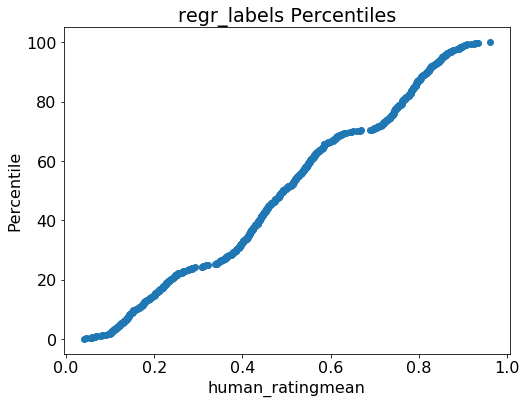

In [127]:
# Plot percentiles for grades
plt.figure(figsize = (8, 6))
plt.plot(df[target_col], df['percentile'], 'o')
# plt.xticks(range(0, 1,.1), range(0, 1,.1))
plt.xlabel(target_col); plt.ylabel('Percentile'); plt.title('regr_labels Percentiles');

In [128]:
print('50th percentile score:', np.min(df.loc[df['percentile'] > 50, target_col]))
print('Minimum Score needed for 90th percentile:', np.min(df.loc[df['percentile'] > 90, target_col]))

50th percentile score: 0.4926315789473684
Minimum Score needed for 90th percentile: 0.8191666666666667


In [129]:
df = df.sort_values(['filename', 'type'])
df

,filename,type,class,human_ratingmean,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,percentile
1,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,1,0.812000,1.853032,0.398556,0.144556,-0.026213,0.010690,89.125561
2,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,2,0.802500,1.880028,0.429649,0.050169,-0.006649,0.040476,87.780269
3,JavierGeneratedData_3dinterleaved_3classes_Gli...,abstract,3,0.804000,1.860662,0.444598,0.112088,-0.070397,-0.016060,87.892377
0,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,1,0.818667,1.853032,0.398556,0.144556,-0.026213,0.010690,89.910314
4,JavierGeneratedData_3dinterleaved_3classes_Gli...,semantic,2,0.766667,1.880028,0.429649,0.050169,-0.006649,0.040476,80.829596
...,...,...,...,...,...,...,...,...,...,...
891,yeast_PCA,abstract,1,0.136786,-1.869965,0.446099,0.527367,0.068599,0.156599,6.614350
884,yeast_PCA,semantic,4,0.285000,-2.965185,0.329452,-0.602338,0.324182,-0.118977,23.878924
885,yeast_PCA,semantic,3,0.481250,-2.047838,-0.005154,-0.097139,-0.274046,-0.243539,47.645740
886,yeast_PCA,semantic,2,0.436250,-1.930844,-0.115132,0.115566,-0.031847,-0.143009,39.686099


# Variable Correlations with Final Grade

## Numerical Correlations

In [130]:
# Correlations of numerical values
df.corr()[target_col].sort_values()

class              -0.207138
PCA_5              -0.096329
PCA_3               0.011540
PCA_2               0.044727
PCA_4               0.155726
PCA_1               0.848873
percentile          0.995090
human_ratingmean    1.000000
Name: human_ratingmean, dtype: float64

## Categorical Correlations using One-Hot Encoding

In [131]:
# Select only categorical variables
category_df = df.select_dtypes('object')
# One hot encode the variables
dummy_df = pd.get_dummies(category_df)
# Put the grade back in the dataframe
dummy_df[target_col] = df[target_col]
dummy_df.head()

,filename_JavierGeneratedData_3dinterleaved_3classes_GlimmerMDS,filename_JavierGeneratedData_3dinterleaved_4classes_PCA,filename_JavierGeneratedData_3dinterleaved_4classes_RobPCA,filename_JavierGeneratedData_3dinterleaved_5classes_GlimmerMDS,filename_JavierGeneratedData_3dinterleaved_5classes_RobPCA,filename_JavierGeneratedData_3dinterleaved_5classes_tSNE,filename_abalone_GlimmerMDS,filename_abalone_PCA,filename_bbdm13_PCA,filename_bbdm13_tSNE,...,filename_world_11d_RobPCA,filename_world_11d_tSNE,filename_world_9d_PCA,filename_worldmap_GlimmerMDS,filename_worldmap_PCA,filename_worldmap_RobPCA,filename_yeast_PCA,type_abstract,type_semantic,human_ratingmean
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.812000
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.802500
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.804000
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.818667
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.766667


In [132]:
# Correlations in one-hot encoded dataframe
dummy_df.corr()[target_col].sort_values()

filename_swanson_GlimmerMDS                                     -0.150412
filename_cars03Cropped_d3_RobPCA                                -0.146699
filename_efashion_GlimmerMDS                                    -0.129474
filename_italianwines_RobPCA                                    -0.128931
filename_italianwines_PCA                                       -0.124058
                                                                   ...   
filename_olive_tSNE                                              0.126824
filename_ms_interleaved_60_120_3d_0_centeredClusters_tSNE        0.131583
filename_JavierGeneratedData_3dinterleaved_5classes_tSNE         0.144537
filename_interleaved_100_200_15d_0_notcramped_notrotated_tSNE    0.155434
human_ratingmean                                                 1.000000
Name: human_ratingmean, Length: 126, dtype: float64

# Select 6 Most Correlated Variables with Final Score

In [187]:
# Takes in a dataframe, finds the most correlated variables with the
# grade and returns training and testing datasets
def format_data(df, target_col='human_rating.mean'):
    # Targets are final grade of student
    labels = df[target_col]
    
    ddf = pd.get_dummies(df[['type']])    
    ddf = pd.concat([df,ddf], axis=1)

    ddf = ddf.loc[:, [target_col, 'filename', 'class',  'type_abstract','percentile'] +[col.replace('.','') for col in best_cols] ]

    
    ddf = ddf.drop(['percentile','filename','class'],axis=1)
    # Split into training/testing sets with 25% split
    X_train, X_test, y_train, y_test = train_test_split(ddf, labels, 
                                                        test_size = 0.2,
                                                        random_state=42, shuffle=False)
    
    
    
    return X_train, X_test, y_train, y_test

In [134]:
X_train, X_test, y_train, y_test = format_data(df)
X_train.head()

,human_ratingmean,type_abstract,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
1,0.812000,1,1.853032,0.398556,0.144556,-0.026213,0.010690
2,0.802500,1,1.880028,0.429649,0.050169,-0.006649,0.040476
3,0.804000,1,1.860662,0.444598,0.112088,-0.070397,-0.016060
0,0.818667,0,1.853032,0.398556,0.144556,-0.026213,0.010690
4,0.766667,0,1.880028,0.429649,0.050169,-0.006649,0.040476


In [135]:
X_test.head()

,human_ratingmean,type_abstract,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
716,0.382500,1,-0.017404,-0.617758,0.290892,0.110104,0.357762
710,0.287333,0,-2.579751,0.355350,-0.816380,0.165194,0.166834
711,0.457368,0,-1.328930,-0.377182,-0.129527,-0.174764,0.587618
714,0.250625,0,-2.787252,0.322571,-0.801010,0.317486,-0.021499
717,0.608421,0,-0.017404,-0.617758,0.290892,0.110104,0.357762


In [136]:
idx_train = X_train.index
idx_test = X_test.index

print(set(df.loc[idx_train, 'filename']).intersection(set(df.loc[idx_test, 'filename'])))


{'n500-d10-c5-spr0.2-out0_GlimmerMDS'}


## Pairs Plot of Selected Variables

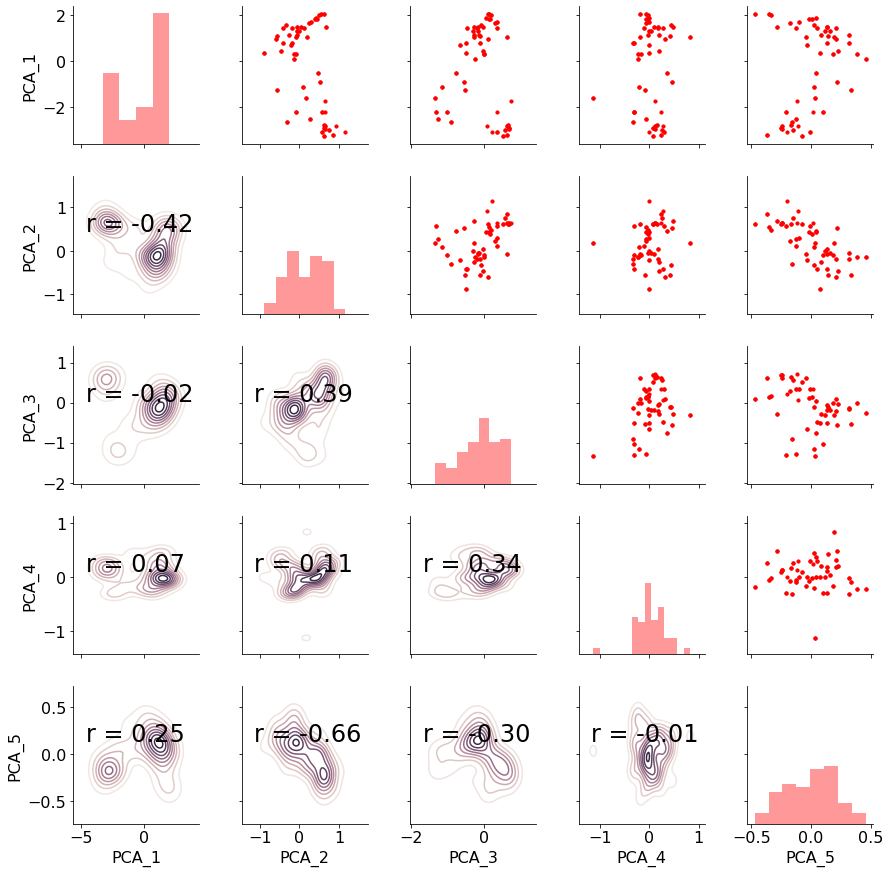

In [137]:
# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(X_train.iloc[:100,2:8])

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [138]:
# Create relation to the median grade column
X_plot = X_train.copy()
X_plot['relation_median'] = (X_plot[target_col] >= np.median(df[target_col]))
X_plot['relation_median'] = X_plot['relation_median'].replace({True: 'above', False: 'below'})
X_plot = X_plot.drop(columns=target_col)

### Selected Variables Distribution by Relation to Median

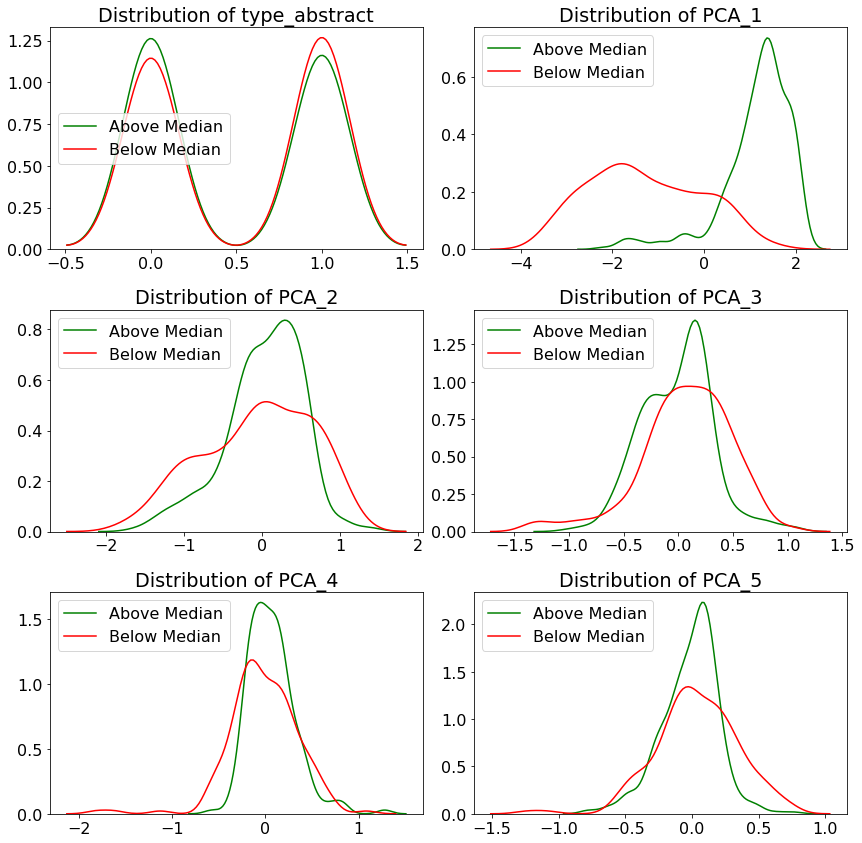

In [139]:
plt.figure(figsize=(12, 12))
# Plot the distribution of each variable colored
# by the relation to the median grade
for i, col in enumerate(X_plot.columns[:-1]):
    if i < 6:

        plt.subplot(3, 2, i + 1)
        subset_above = X_plot[X_plot['relation_median'] == 'above']
        subset_below = X_plot[X_plot['relation_median'] == 'below']
        sns.kdeplot(subset_above[col], label = 'Above Median', color = 'green')
        sns.kdeplot(subset_below[col], label = 'Below Median', color = 'red')
        plt.legend(); plt.title('Distribution of %s' % col)
    
plt.tight_layout()

# Establish Benchmarks

## Metrics

For this regression task, we will use two standard metrics:

* Mean Absolute Error (MAE): Average of the absolute value of the difference between predictions and the true values
* Root Mean Squared Error (RMSE): The square root of the average of the squared differences between the predictions and the true values.

The mean absolute error is more interpretable, but the root mean squared error penalizes larger errors more heavily. Either one may be appropriate depending on the situation. 
[Here is a discussion](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d).

In [140]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

### Naive Baseline

For a regression task, a simple naive baseline is to guess the median value on the training set for all testing cases. If our machine learning model cannot better this simple baseline, then perhaps we should try a different approach! 

In [141]:
# Naive baseline is the median
median_pred = X_train[target_col].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test[target_col]

In [142]:
# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 0.1956
Median Baseline RMSE: 0.2378


## Standard Machine Learning Models

In [143]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    X_train = X_train.drop([target_col], axis=1)
    X_test = X_test.drop([target_col], axis=1)
    
    print(X_train.columns)
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Plots
        fig, ax = plt.subplots(figsize=(5,5))
        sns.scatterplot(predictions, y_test)
        
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

Index(['type_abstract', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5'], dtype='object')


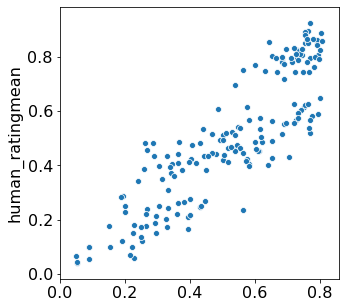

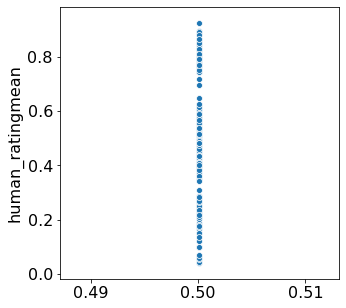

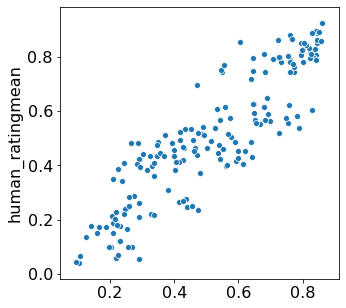

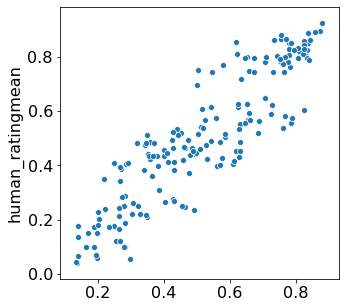

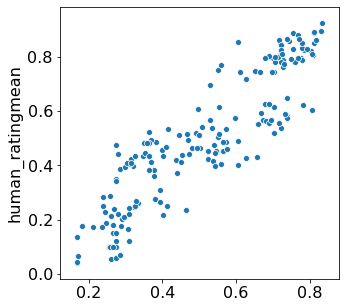

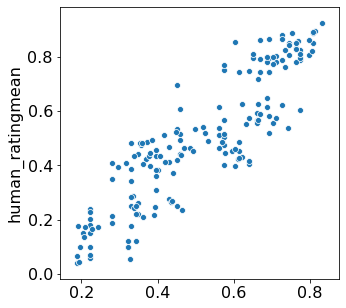

In [144]:
# X_train = X_train.drop([target_col,'class'], axis=1)
# X_test = X_test.drop([target_col,'class'], axis=1)
results = evaluate(X_train, X_test, y_train, y_test)

#### Visual Comparison of Models

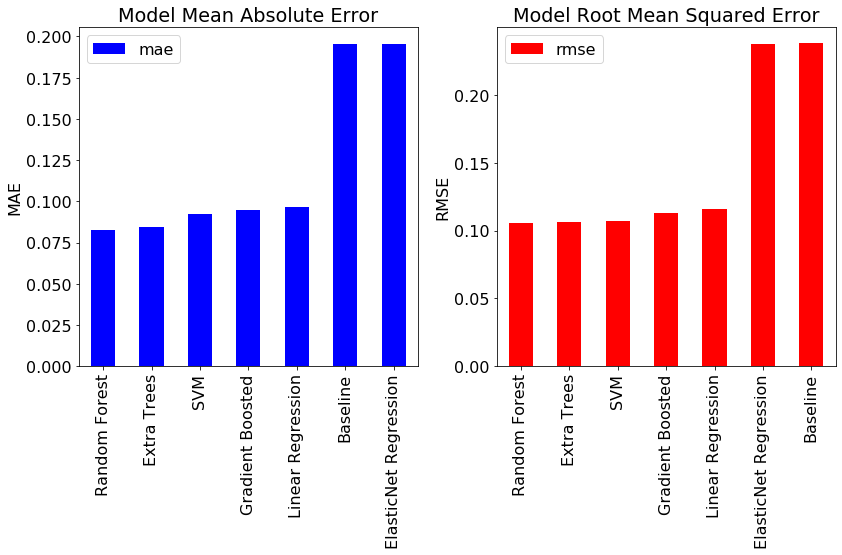

In [145]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 16
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()

In [146]:
results

,mae,rmse
Linear Regression,0.0963622,0.115581
ElasticNet Regression,0.195729,0.237736
Random Forest,0.0828676,0.105538
Extra Trees,0.0843557,0.105992
SVM,0.0920625,0.107394
Gradient Boosted,0.0948125,0.112582
Baseline,0.19563,0.237774


In [199]:
print('The Random Forest regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(0.08 - results.loc['Baseline', 'mae']
              )) / results.loc['Baseline', 'mae']))

The Random Forest regressor is 59.11% better than the baseline.


## Formula from Ordinary Least Squares Linear Regression

In [148]:
lr = LinearRegression()
lr.fit(X_train, y_train)

ols_formula = 'target_col = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns[1:]):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'target_col = -0.00 + 1.00 * type_abstract + -0.00 * PCA_1 + -0.00 * PCA_2 + 0.00 * PCA_3 + -0.00 * PCA_4 + 0.00 * PCA_5'

# Implementing Bayesian Linear Regression

In [149]:
# Formula for Bayesian Linear Regression (follows R formula syntax
formula = '{} ~ '.format(target_col) + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'human_ratingmean ~ type_abstract + PCA_1 + PCA_2 + PCA_3 + PCA_4 + PCA_5'

## Create Model in PyMC3 and Sample from Posterior

We now build the model using the formula defined above and a normal distribution for the data likelihood. Then, we let a Markov Chain Monte Carlo algorithm draw samples from the posterior to approximate the posterior for each of the model parameters.

In [150]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 500, target_accept=.9, cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [sd, PCA_5, PCA_4, PCA_3, PCA_2, PCA_1, type_abstract, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:08<00:00, 600.82draws/s]


In [151]:
import pickle 


filename = 'bayes_best.pickle'
outfile = open(filename,'wb')

pickle.dump(normal_trace,outfile)
outfile.close()

In [152]:
infile = open(filename,'rb')
old_trace = pickle.load(infile)
infile.close()

In [153]:
X_train

,human_ratingmean,type_abstract,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
1,0.812000,1,1.853032,0.398556,0.144556,-0.026213,0.010690
2,0.802500,1,1.880028,0.429649,0.050169,-0.006649,0.040476
3,0.804000,1,1.860662,0.444598,0.112088,-0.070397,-0.016060
0,0.818667,0,1.853032,0.398556,0.144556,-0.026213,0.010690
4,0.766667,0,1.880028,0.429649,0.050169,-0.006649,0.040476
...,...,...,...,...,...,...,...
703,0.746667,0,1.340557,0.274367,-0.069850,0.109470,-0.134813
702,0.530000,0,1.254399,0.207633,-0.017057,-0.257711,0.028279
712,0.131875,1,-2.787252,0.322571,-0.801010,0.317486,-0.021499
713,0.158235,1,-2.579751,0.355350,-0.816380,0.165194,0.166834


# Examine Bayesian Linear Regression Results

## Traceplot of All Samples

In [154]:
# Shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(pm.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

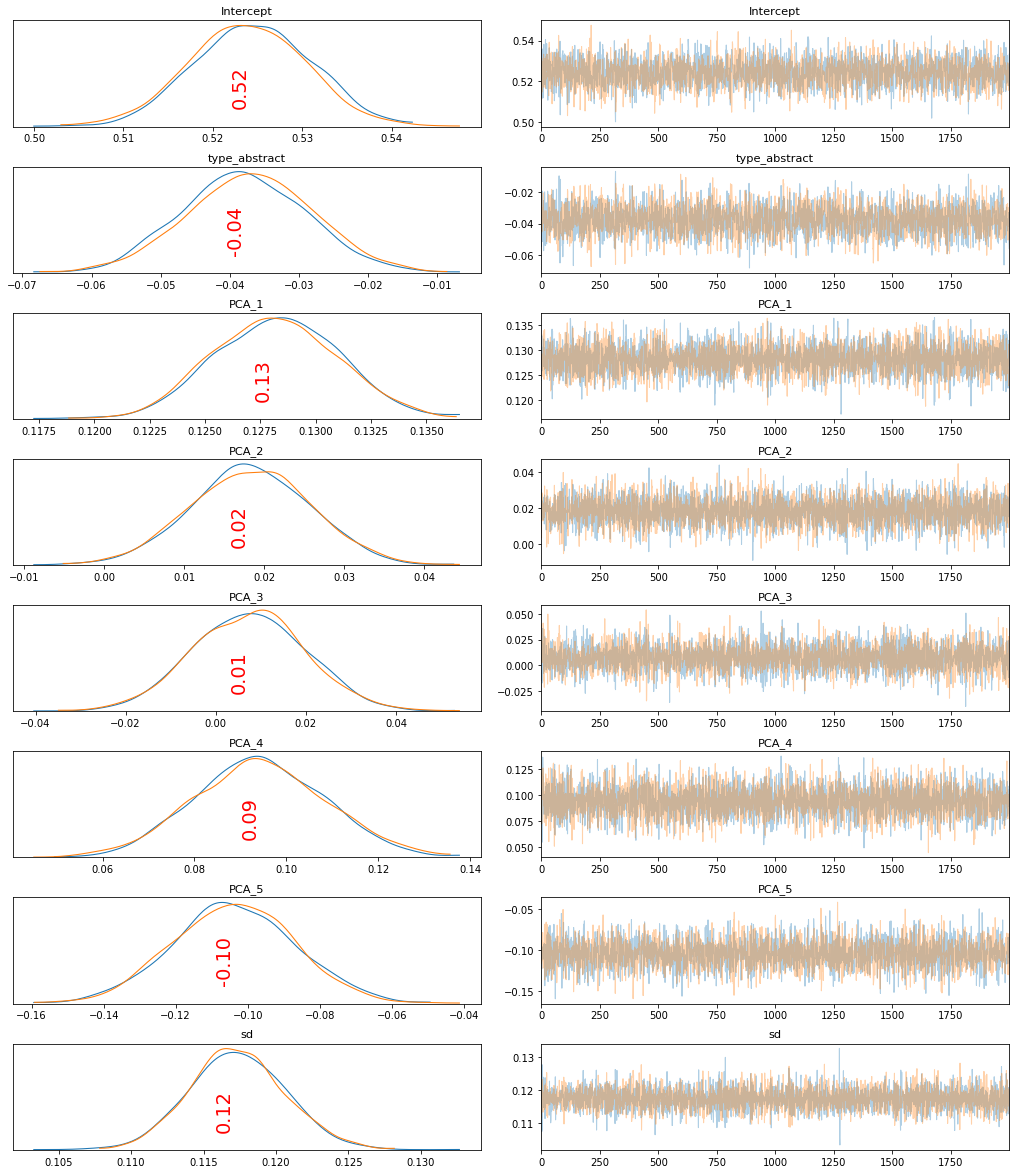

In [155]:
import warnings
warnings.filterwarnings("ignore")

plot_trace(normal_trace)

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs. 

Another method built into PyMC3 for examinig trace results is the forestplot which shows the distribution of each sampled parameter. This allows us to see the uncertainty in each sample. The forestplot is easily constructed from the trace using `pm.forestplot`.

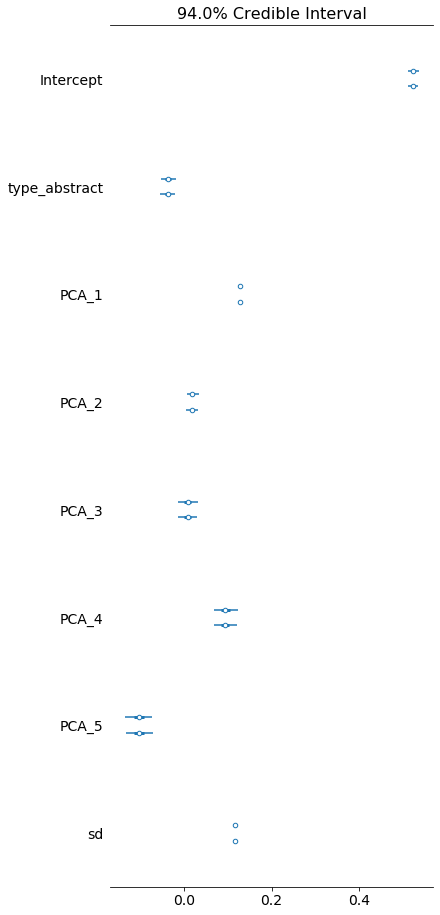

In [156]:
pm.forestplot(normal_trace);

From the forest plot we can see the most likely value of the parameter (the dot) as well as the 95% credible interval for the parameter. The `intercept` and `higher_edu` have larger uncertainty compared to the other variables. 

Another built in plotting method in PyMC3 is the posterior distribution of all the model parameters. These histograms allow us to see how the model result is a distribution for the parameters rather than a single value.

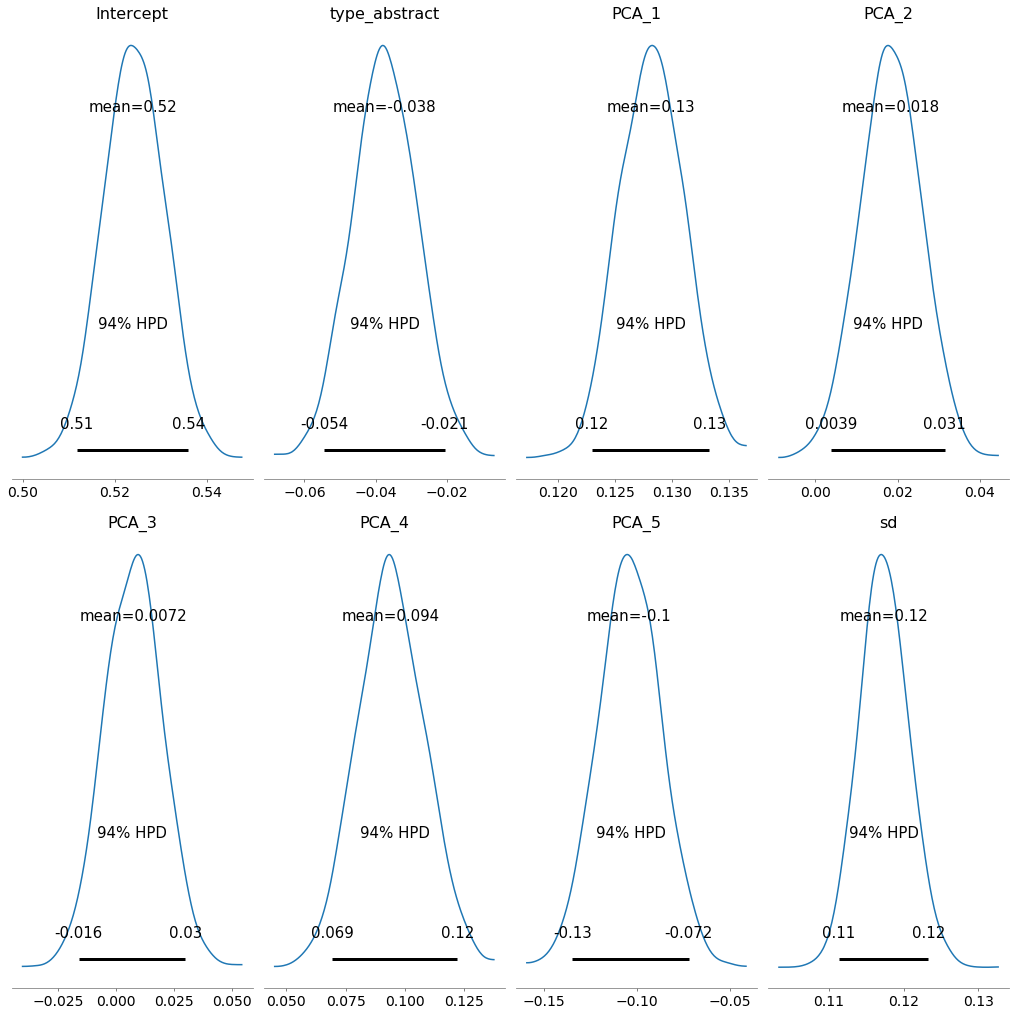

In [157]:
pm.plot_posterior(normal_trace, figsize = (14, 14));

In [158]:
# Print out the mean variable weight from the trace
for variable in normal_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, 
                                                                np.mean(normal_trace[variable])))

Variable: Intercept       Mean weight in model: 0.5241
Variable: type_abstract   Mean weight in model: -0.0376
Variable: PCA_1           Mean weight in model: 0.1282
Variable: PCA_2           Mean weight in model: 0.0182
Variable: PCA_3           Mean weight in model: 0.0072
Variable: PCA_4           Mean weight in model: 0.0941
Variable: PCA_5           Mean weight in model: -0.1041
Variable: sd_log__        Mean weight in model: -2.1433
Variable: sd              Mean weight in model: 0.1173


## Interpretations of Weights

Based on the sign and location of the weights, we can make the following inferences regarding the features in our dataset:

* Previous class failures are negatively related to the students final grade
* Higher education ambitions are positively related to the students grade
* The mother's and father's education levels are positively related to the students final grade
* Studying time per week is positively related to the students final grade
* Absences are negatively related to the students final grade

In [159]:
pm.summary(normal_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.524,0.006,0.512,0.536,0.0,0.0,3155.0,3152.0,3148.0,3052.0,1.0
type_abstract,-0.038,0.009,-0.054,-0.021,0.0,0.0,3128.0,3106.0,3171.0,2815.0,1.0
PCA_1,0.128,0.003,0.123,0.133,0.0,0.0,5536.0,5536.0,5551.0,3149.0,1.0
PCA_2,0.018,0.007,0.004,0.031,0.0,0.0,5572.0,4943.0,5569.0,3172.0,1.0
PCA_3,0.007,0.012,-0.016,0.030,0.0,0.0,5209.0,2284.0,5199.0,3004.0,1.0
PCA_4,0.094,0.014,0.069,0.122,0.0,0.0,5661.0,5499.0,5655.0,3092.0,1.0
PCA_5,-0.104,0.017,-0.135,-0.072,0.0,0.0,4157.0,4083.0,4152.0,3148.0,1.0
sd,0.117,0.003,0.111,0.123,0.0,0.0,6041.0,6041.0,5996.0,2720.0,1.0


### Linear Formula from Bayesian Inference using Mean of Parameters

In [160]:
model_formula = '{} = '.format(target_col)
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'human_ratingmean =  0.52 * Intercept + -0.04 * type_abstract + 0.13 * PCA_1 + 0.02 * PCA_2 + 0.01 * PCA_3 + 0.09 * PCA_4 + -0.10 * PCA_5 + -2.14 * sd_log__ + 0.12 * sd'

## Evaluate Bayesian Model Using Mean of Model Parameters

In [161]:
# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.ix[:, names]
    var_means = var_means[names]
    
    
            


    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.ix[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
        
    
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    
    # Plots
    fig, ax = plt.subplots(figsize=(5,5))
    sns.scatterplot(results['estimate']
                    , y_test)
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    # Add the results to the comparison dataframe
    model_results.ix['Bayesian LR', :] = [mae, rmse]
    
    plt.figure(figsize=(12, 8))
    
    # Plot median absolute percentage error of all models
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'r', ax = ax)
    plt.title('Model Mean Absolute Error Comparison'); plt.ylabel('MAE'); 
    plt.tight_layout()
    
    # Plot root mean squared error of all models
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')
    
    return model_results

Model  MAE: 0.0963
Model RMSE: 0.1156


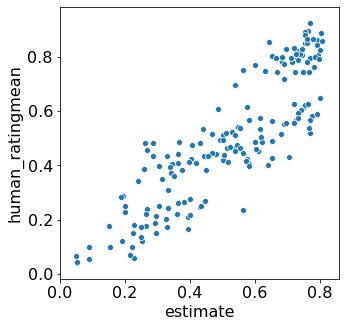

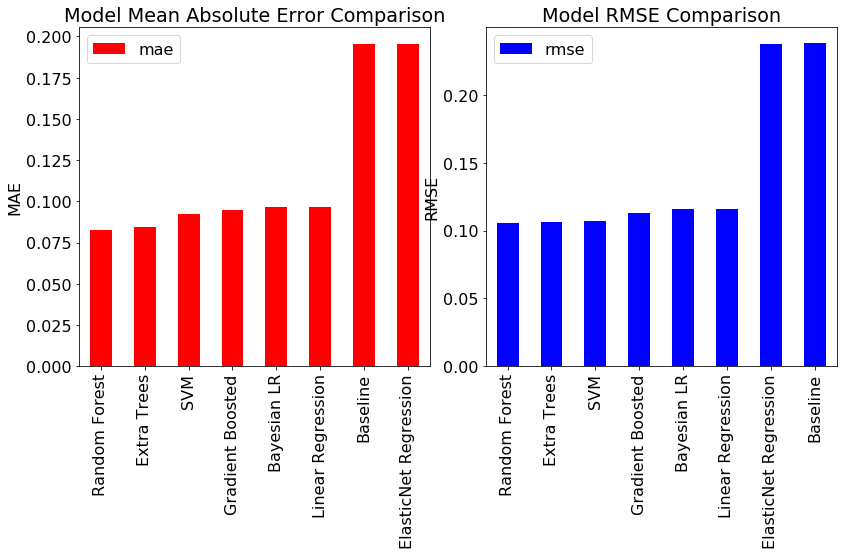

In [162]:
all_model_results = evaluate_trace(normal_trace, X_train, X_test, y_train, y_test, results)

In [163]:
all_model_results

,mae,rmse
Linear Regression,0.0963622,0.115581
ElasticNet Regression,0.195729,0.237736
Random Forest,0.0828676,0.105538
Extra Trees,0.0843557,0.105992
SVM,0.0920625,0.107394
Gradient Boosted,0.0948125,0.112582
Baseline,0.19563,0.237774
Bayesian LR,0.0963392,0.115552


# Make Predictions from Model

## Test Observations

In [179]:
# Make a new prediction from the test set and compare to actual value
def test_model(trace, test_observation, ax):
    
    # Print out the test observation data
#     print('Test Observation:')
#     print(test_observation)
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]

    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()

    # Actual Value
    actual = test_observation[target_col]
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop(target_col)
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]

    # Means for all the weights
    var_means = var_weights.mean(axis=0)

    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates of grade
    estimates = np.random.normal(loc = mean_loc, scale = sd_value,
                                 size = 1000)

    # Plot all the estimates
    
    sns.distplot(estimates, hist = False, kde = True, bins = 19,
                 hist_kws = {'edgecolor': 'k', 'color': 'darkblue'},
                kde_kws = {'linewidth' : 2},
                label = 'Estimated Dist.', ax=ax)
    # Plot the actual grade
    ax.vlines(x = actual, ymin = 0, ymax = 5, 
               linestyles = '--', colors = 'red',
               label = 'True Grade',
              linewidth = 2.5)
    
    # Plot the mean estimate
    ax.vlines(x = mean_loc, ymin = 0, ymax = 5, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    
    #ax.title('Density Plot for Test Observation');
    ax.set_xlabel(target_col); 
    
    # Prediction information
#     print('True {} = {}'.format(target_col, actual))
#     print('Average Estimate = %0.4f' % mean_loc)
#     print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
#                                        np.percentile(estimates, 95)))

In [189]:
df1 = pd.read_csv('df_clean_dr.csv')
dX_train, dX_test, dy_train, dy_test = format_data(df1, target_col='human_rating')

In [196]:
sorted(list(set(df1.filename)))

names = ['JavierGeneratedData_3dinterleaved_3classes_GlimmerMDS',
 'abalone_GlimmerMDS',
 'abalone_PCA',
 'bbdm13_PCA',
 'boston_tSNE',
 'cars03Cropped_d2_PCA',
 'cereal_tSNE',
 'efashion_GlimmerMDS',
 'efashion_PCA',
 'fisheries_clusteredByEscapementTarget_GlimmerMDS',
 'grid10_3d_GlimmerMDS',
 'grid10_3d_tSNE',
 'grid6_4d_GlimmerMDS',
 'grid6_4d_RobPCA',
 'grid6_4d_tSNE',
 'hiv_GlimmerMDS',
 'interleaved_100_200_10d_0_notcramped_notrotated_GlimmerMDS',
 'iris_tSNE',
 'italianwines_PCA',
 'italianwines_tSNE',
 'ms_interleaved_120_240_3d_25_centeredClusters_RobPCA',
 'n100-d10-c3-spr0.1-out0_GlimmerMDS',
 'olive_GlimmerMDS',
 'olive_RobPCA',
 'olive_tSNE',
 'swanson_GlimmerMDS',
 'tse300_PCA',
 'white_ballance_RobPCA',
 'wine_RobPCA',
 'world_11d_tSNE',
 'world_9d_PCA',
 'worldmap_GlimmerMDS',
 'worldmap_PCA',
 'worldmap_RobPCA',
 'yeast_PCA']

df.loc[df1['filename'].isin(names)]

,filename,type,class,human_ratingmean,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,percentile
712,n500-d10-c5-spr0.2-out0_GlimmerMDS,abstract,4,0.131875,-2.787252,0.322571,-0.801010,0.317486,-0.021499,6.165919
713,n500-d10-c5-spr0.2-out0_GlimmerMDS,abstract,3,0.158235,-2.579751,0.355350,-0.816380,0.165194,0.166834,9.977578
715,n500-d10-c5-spr0.2-out0_GlimmerMDS,abstract,1,0.198235,-1.328930,-0.377182,-0.129527,-0.174764,0.587618,14.573991
716,n500-d10-c5-spr0.2-out0_GlimmerMDS,abstract,2,0.382500,-0.017404,-0.617758,0.290892,0.110104,0.357762,29.596413
710,n500-d10-c5-spr0.2-out0_GlimmerMDS,semantic,3,0.287333,-2.579751,0.355350,-0.816380,0.165194,0.166834,24.103139
...,...,...,...,...,...,...,...,...,...,...
891,yeast_PCA,abstract,1,0.136786,-1.869965,0.446099,0.527367,0.068599,0.156599,6.614350
884,yeast_PCA,semantic,4,0.285000,-2.965185,0.329452,-0.602338,0.324182,-0.118977,23.878924
885,yeast_PCA,semantic,3,0.481250,-2.047838,-0.005154,-0.097139,-0.274046,-0.243539,47.645740
886,yeast_PCA,semantic,2,0.436250,-1.930844,-0.115132,0.115566,-0.031847,-0.143009,39.686099


KeyError: 'filename'

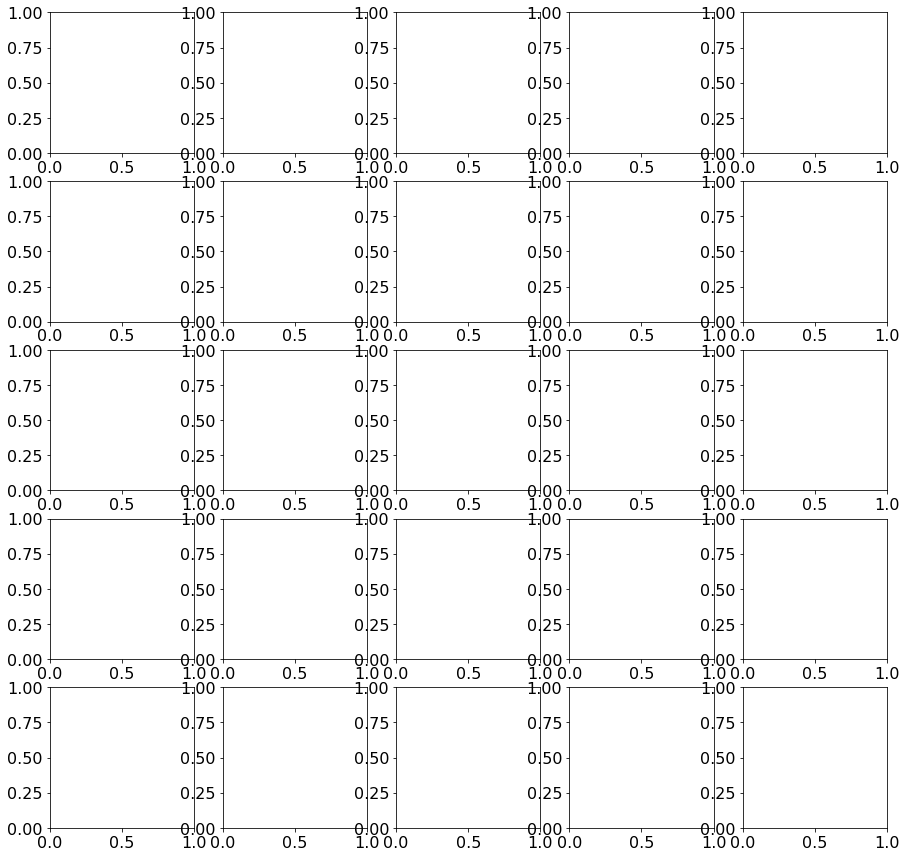

In [197]:


f, ax = plt.subplots(5,5, figsize=(15, 15))
for i in names:
    test_model(normal_trace, X_test.loc[X_test['filename']==name], ax[i%5,i//5])
    
ax[0,0].legend(loc = 1)

In [112]:
X_test

,human_ratingmean,type_abstract,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,Intercept
716,0.382500,1,-0.017404,-0.617758,0.290892,0.110104,0.357762,1
710,0.287333,0,-2.579751,0.355350,-0.816380,0.165194,0.166834,1
711,0.457368,0,-1.328930,-0.377182,-0.129527,-0.174764,0.587618,1
714,0.250625,0,-2.787252,0.322571,-0.801010,0.317486,-0.021499,1
717,0.608421,0,-0.017404,-0.617758,0.290892,0.110104,0.357762,1
...,...,...,...,...,...,...,...,...
891,0.136786,1,-1.869965,0.446099,0.527367,0.068599,0.156599,1
884,0.285000,0,-2.965185,0.329452,-0.602338,0.324182,-0.118977,1
885,0.481250,0,-2.047838,-0.005154,-0.097139,-0.274046,-0.243539,1
886,0.436250,0,-1.930844,-0.115132,0.115566,-0.031847,-0.143009,1


#### Predictions for New Observation

In [114]:
# observation = pd.Series({'Intercept': 1, 'mother_edu': 2, 'failures': 2, 
#                             'higher_edu': 1, 'studytime': 2,
#                             'father_edu': 3, 'absences': 4})
# query_model(normal_trace, observation)

# Model Variable Effects

If we want to see the effect of changing one variable while holding the others constant, we can use the function `pm.plot_posterior_predictive_glm`. This takes a range of values to use for the variable, a linear model, and a number of samples. The function evaluates the linear model across the range of values for the number of samples. Each time, it draws a different set of parameters from the trace. This gives us an indication of the effect of a single variable and also the uncertainty in the model estimates. To see the effect of a single variable, we hold the others constant at their median values.

In [166]:
# Examines the effect of changing a single variable
# Takes in the name of the variable, the trace, and the data
def model_effect(query_var, trace, X):
    
    # Variables that do not change
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    # Linear Model that estimates a grade based on the value of the query variable 
    # and one sample from the trace
    def lm(value, sample):
        
        # Prediction is the estimate given a value of the query variable
        prediction = sample['Intercept'] + sample[query_var] * value
        
        # Each non-query variable is assumed to be at the median value
        for var in steady_vars:
            
            # Multiply the weight by the median value of the variable
            prediction += sample[var] * X[var].median()
        
        return prediction
    
    figsize(6, 6)
    
    # Find the minimum and maximum values for the range of the query var
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the estimated grade versus the range of query variable
    pm.plot_posterior_predictive_glm(trace, eval=np.linspace(var_min, var_max, 100), 
                                     lm=lm, samples=100, color='blue', 
                                     alpha = 0.4, lw = 2)
    
    # Plot formatting
    plt.xlabel('%s' % query_var, size = 16)
    plt.ylabel(target_col, size = 16)
    plt.title("Posterior of {} vs {}".format(target_col, query_var), size = 18)
    plt.show()

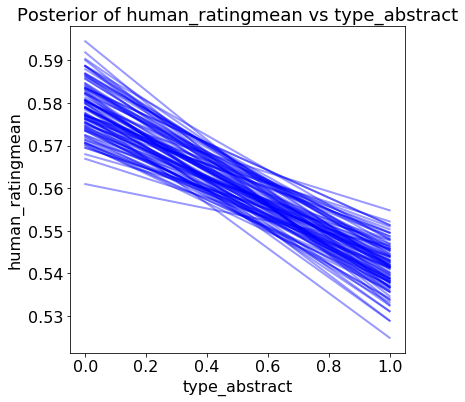

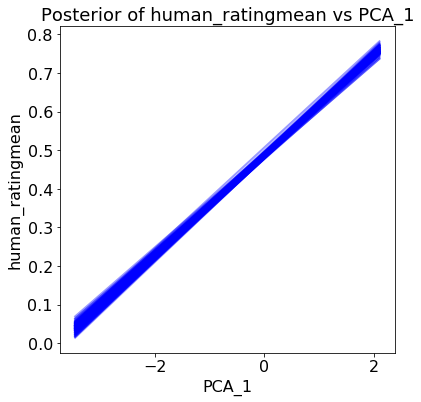

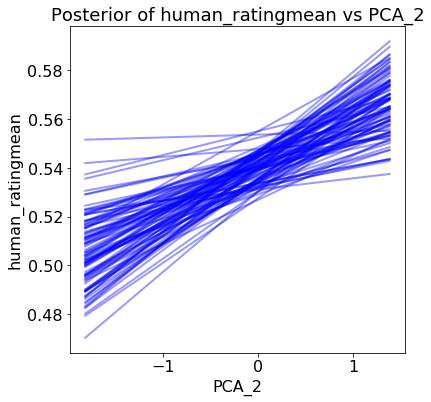

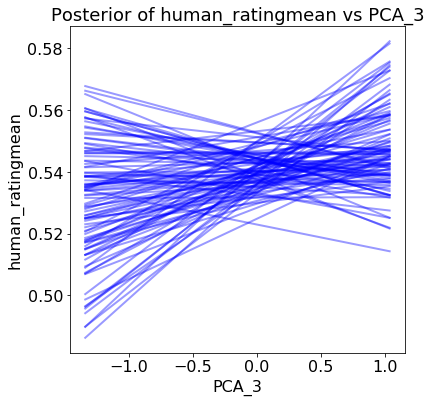

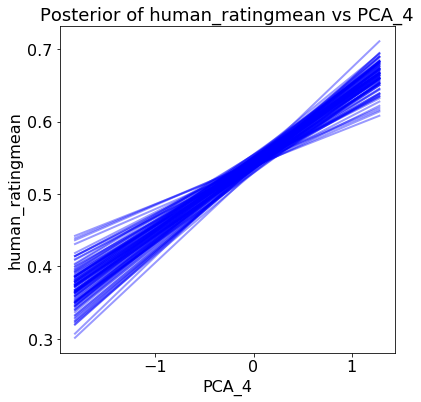

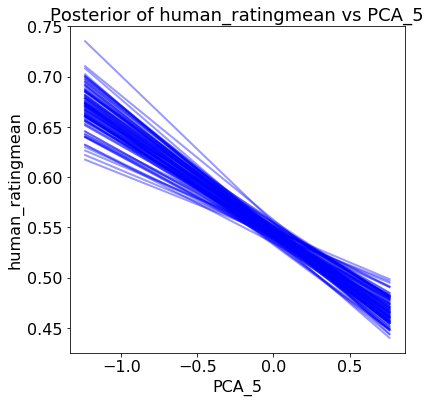

In [167]:
cols =list(X_train.columns[1:])

for c in cols:
    model_effect(c, normal_trace, X_train.drop(columns=target_col))